# Combining Models

Now we might want to combine different models together. For example, we might want to fit a transit simultaneously with its systematics (polynomials in time, x, y, background etc.). This is very similar to the Transit and Polynomial tutorials, so if you haven't looked at those tutorials I recommend you do before this one!

In [1]:
# import chromatic_fitting of course!
from chromatic_fitting import *

# import any prior distributions we want to use for our parameters - I've chosen Normal and Uniform from pymc3
# and QuadLimbDark and ImpactParameter from exoplanet
from pymc3 import Normal, Uniform
from exoplanet import QuadLimbDark, ImpactParameter

# import astropy table just for this tutorial (pandas dataframes don't show up nicely on the docs pages!)
from astropy.table import Table

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.6.3!

This program is running on:
Python v3.9.15 (main, Nov  4 2022, 11:12:28) 
[Clang 12.0.0 ]
numpy v1.21.6
chromatic v0.4.5
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


Generate some simulated data. This time we will use the handy `.inject_systematics()` and `.inject_noise()` functions in `chromatic`

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

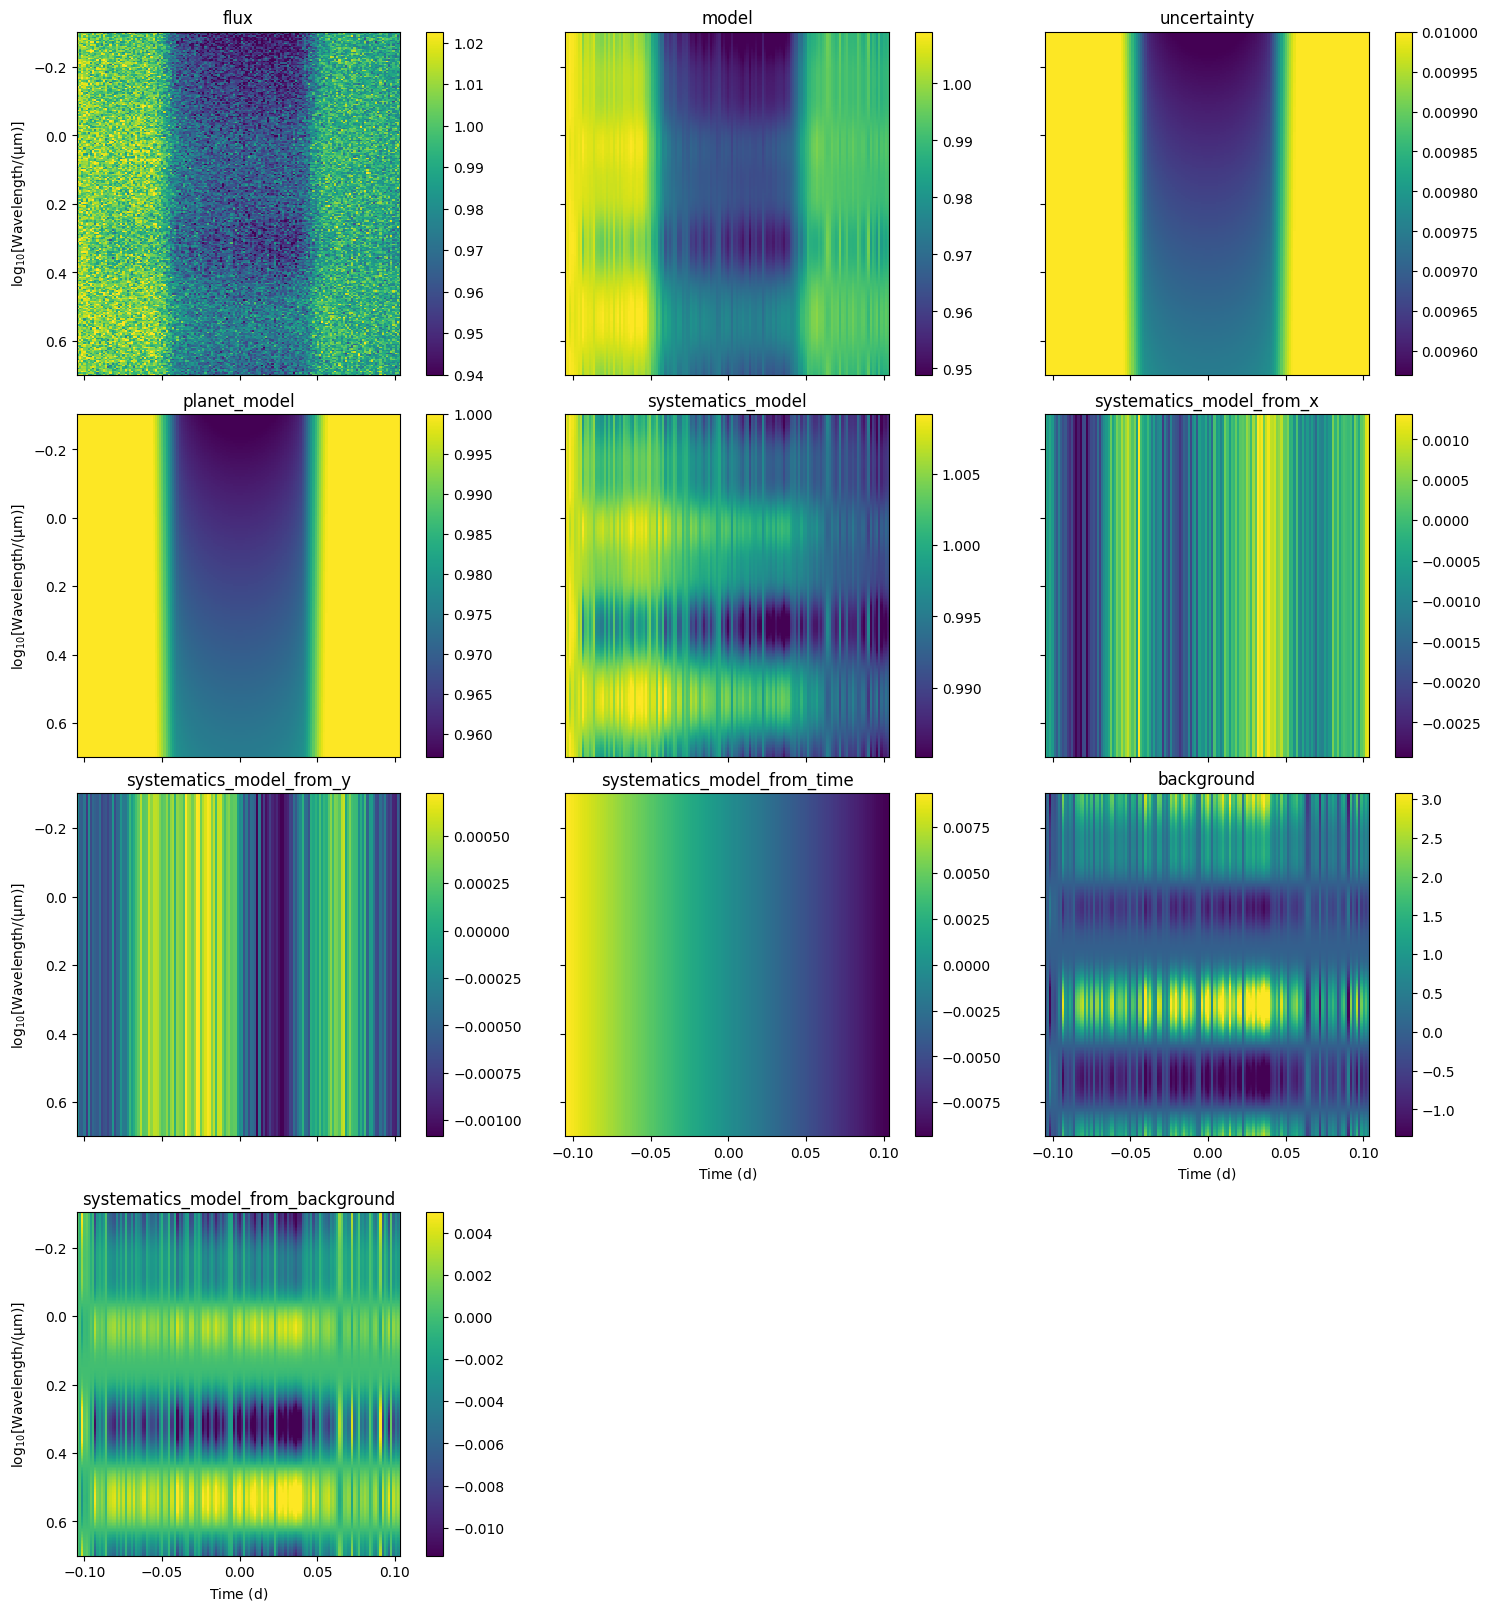

In [2]:
# create a basic simulated data set
s = SimulatedRainbow()
# inject a transit and noise as well as systematics in x, y, background and time.
s = s.inject_transit(planet_radius=np.linspace(0.2, 0.15, s.nwave)).inject_noise(signal_to_noise=100).inject_systematics(amplitude=0.005)

# show all the Rainbow.fluxlike quantities:
s.imshow_quantities();
# finally, we will bin our lightcurves to make this tutorial run faster!
nwave = 3
s = s.bin(nwavelengths=int(s.nwave/nwave), dt=5 * u.minute)

Set up the transit and polynomial models. This is where we can set the distributions for every parameter, the names of the models, the degree of the polynomials, the variables we want to relate the polynomials to, etc. Here we decided to just model linear polynomials (with degree=1) for each systematic variable: 

In [3]:
# set up transit model:
t = TransitModel()
t.setup_parameters(
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.1, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(Uniform,testval=[0.05,0.35],shape=2),
                    baseline = WavelikeFitted(Normal, mu=1.0, sigma=0.1)
                )

# set up time polynomial model:
b = PolynomialModel(degree=1, name='stime')
b.setup_parameters(
    p_0 = 1.0,
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up x polynomial model:
b_x = PolynomialModel(degree=1, independant_variable="x", name='sx')
b_x.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up y polynomial model:
b_y = PolynomialModel(degree=1, independant_variable="y", name='sy')
b_y.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up bkg polynomial model:
b_bkg = PolynomialModel(degree=1, independant_variable="background", name='sbkg')
b_bkg.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

We can combine the models by using the standard arithmetic operators: +, -, * and /. In this case I will multiply the transit model by the sum of all the systematic polynomials. *Note: we have to be careful here not to have multiple different variables that all describe some constant offset.* For example, in the transit model we have the 'baseline' parameter that determines the out-of-transit constant flux. But in the polynomials we can also fit for the 0th order flux, 'p_0'. We should be careful not to fit for both! (By default 'p_0' will be set to 0.0 in the models where we don't define it.)

In [4]:
cmod = t * (b + b_x + b_y + b_bkg)
cmod

/Users/camu5866/opt/anaconda3/envs/spec_meeting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:182: UserWarning: stime in the parameter name: stime_p_0. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/spec_meeting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:182: UserWarning: sx in the parameter name: sx_p_0. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/spec_meeting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:182: UserWarning: sy in the parameter name: sy_p_0. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/spec_meeting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:182: UserWarning: sbkg in the parameter name: sbkg_p_0. Please avoid having the m

<chromatic combined model 'combined' 🌈, models: <chromatic polynomial model 'stime' 🌈> + <chromatic polynomial model 'sx' 🌈> + <chromatic polynomial model 'sy' 🌈> + <chromatic polynomial model 'sbkg' 🌈> * <chromatic transit model 'transit' 🌈>

The individual models will be stored in a dictionary under `.chromatic_models`:

In [5]:
cmod._chromatic_models

{'stime': <chromatic polynomial model 'stime' 🌈>,
 'sx': <chromatic polynomial model 'sx' 🌈>,
 'sy': <chromatic polynomial model 'sy' 🌈>,
 'sbkg': <chromatic polynomial model 'sbkg' 🌈>,
 'transit': <chromatic transit model 'transit' 🌈>}

Let's see what parameters we have in our models:

In [6]:
cmod.summarize_parameters()

A CombinedModel itself does not have any parameters, however each of its constituent models do:

stime_p_0 =
  <🧮 Fixed | 1.0 🧮>

stime_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='stime_p_1') 🧮>

sx_p_0 =
  <🧮 Fixed | 0.0 🧮>

sx_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sx_p_1') 🧮>

sy_p_0 =
  <🧮 Fixed | 0.0 🧮>

sy_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sy_p_1') 🧮>

sbkg_p_0 =
  <🧮 Fixed | 0.0 🧮>

sbkg_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sbkg_p_1') 🧮>

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.1, sigma=0.05, name='transit_radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 1 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 Wavelike

Then we just attach the Rainbow data to the model and run `.setup_lightcurves()` and `.setup_likelihood()` as in the previous tutorials:

In [7]:
# attach the data to our model
cmod.attach_data(s)

# If we don't want to fit everything simultaneously we can change the optimization method (the options 
# are "separate" or "white_light"). This has to be set BEFORE running .setup_lightcurves!
# cmod.choose_optimization_method('separate')

# The 'store_models' keyword can be useful later to speed up debugging/plotting, but it can slow 
# down/break fitting for large numbers of wavelengths
cmod.setup_lightcurves() # (store_models=True)

# Finally use the observed data to fit the model (assuming Gaussian errors!)
cmod.setup_likelihood()

  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
cmod._chromatic_models

{'stime': <chromatic polynomial model 'stime' 🌈>,
 'sx': <chromatic polynomial model 'sx' 🌈>,
 'sy': <chromatic polynomial model 'sy' 🌈>,
 'sbkg': <chromatic polynomial model 'sbkg' 🌈>,
 'transit': <chromatic transit model 'transit' 🌈>}

If we look at our `PyMC3` model we can see that it has a lot of parameters (the combination of all our models) to optimize! If we've chosen the separate wavelength fitting method (`.choose_optimization_method("separate")`) then `._pymc3_model` will return a list of PyMC3 models (one for each wavelength).

In [9]:
print(cmod._pymc3_model)

                        stime_p_1 ~ Normal
                           sx_p_1 ~ Normal
                           sy_p_1 ~ Normal
                         sbkg_p_1 ~ Normal
         transit_epoch_interval__ ~ TransformedDistribution
transit_impact_parameter_impact__ ~ TransformedDistribution
transit_stellar_radius_interval__ ~ TransformedDistribution
  transit_stellar_mass_interval__ ~ TransformedDistribution
transit_limb_darkening_interval__ ~ TransformedDistribution
             transit_radius_ratio ~ Normal
                 transit_baseline ~ Normal
                    transit_epoch ~ Uniform
         transit_impact_parameter ~ ImpactParameter
           transit_stellar_radius ~ Uniform
             transit_stellar_mass ~ Uniform
                     transit_a_R* ~ Deterministic
           transit_limb_darkening ~ Uniform
                             data ~ Normal


We've got our polynomial parameters (`stime_p_1, sx_p_1, sy_p_1, sbkg_p_1`), our transit parameters that are wavelength-independant in this case (`epoch, impact_parameter, stellar_radius, stellar_mass, a_R*, limb_darkening`) and the wavelength-dependant parameters we've defined to be `radius_ratio_w{N}` only. The `wavelength_{N}_data` parameter just represents the fit of the data to the model at each wavelength (which we've defined to be a Normal distribution). If we've decided to `store_models` then we will also see a bunch of models!

But what do the actual light curves look like?

The summarize step has not been run yet. To include the 'best-fit' model please run {self}.sample() and {self}.summarize() before calling this step!


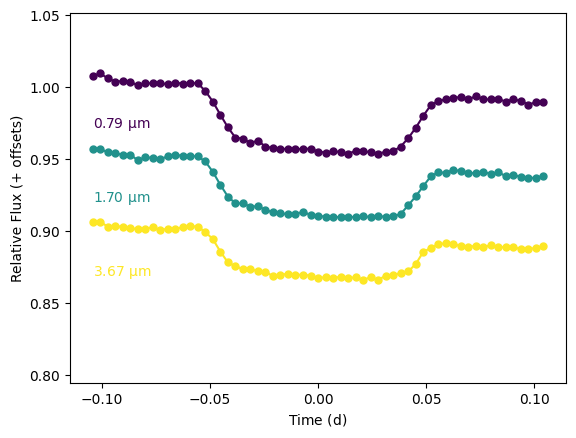

In [10]:
cmod.plot_lightcurves()

We can still see the transit for each wavelength, but it's clear that the systematics would affect any derivation of the transit parameters if we didn't model for these systematics! 

## PyMC3 Sampling

Now we can run the NUTS sampling for our light curves (first by optimizing our initial values)

In [11]:
# optimize for initial values!
opt = cmod.optimize(plot=False)

# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains. NOTE: if you do separate wavelength fitting then the number of steps 
# is per wavelengths, not divided between the wavelengths!
cmod.sample(start=opt, tune=3000, draws=5000, cores=4, chains=4, return_inferencedata=False)

optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Desired error not necessarily achieved due to precision loss.
logp: -66734.63649377623 -> -8431.577154563447


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


Sampling 4 chains for 3_000 tune and 5_000 draw iterations (12_000 + 20_000 draws total) took 172 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


At this stage the sampler may print out some warnings that we don't have enough tuning steps! We can then see the results of our sampling by running `.summarize()`

In [12]:
# print out a nice summary table (or list of tables) of our results!
cmod.summarize(round_to=7, hdi_prob=0.68, fmt='wide')

                                  mean        sd   hdi_16%   hdi_84%  \
stime_p_1[0]                 -0.089371  0.001187 -0.090493 -0.088137   
sx_p_1[0]                    -0.001400  0.000132 -0.001525 -0.001262   
sy_p_1[0]                    -0.000659  0.000095 -0.000750 -0.000564   
sbkg_p_1[0]                  -0.003611  0.000303 -0.003884 -0.003284   
transit_radius_ratio[0]       0.191568  0.000931  0.190683  0.192519   
transit_radius_ratio[1]       0.174990  0.000949  0.174071  0.175969   
transit_radius_ratio[2]       0.158371  0.000908  0.157528  0.159334   
transit_baseline[0]           0.999662  0.000193  0.999475  0.999859   
transit_baseline[1]           0.999769  0.000197  0.999587  0.999974   
transit_baseline[2]           0.999637  0.000158  0.999471  0.999785   
transit_epoch[0]              0.000088  0.000080  0.000003  0.000162   
transit_impact_parameter[0]   0.067801  0.047782  0.000010  0.086426   
transit_stellar_radius[0]     1.180642  0.012001  1.173982  1.19

An important parameter to look out for here to check whether your samplings have converged is [`r_hat`](https://arviz-devs.github.io/arviz/api/generated/arviz.rhat.html#arviz.rhat). This [rank normalized R-hat diagnostic](https://arxiv.org/abs/1903.08008) tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identicalm therefore, the closer it is to 1 the better the chance that your sampling successfully converged. If you're interested in the sampling see the [`PyMC3 docs`](https://docs.pymc.io/en/v3/index.html) for much more detail!

Then we can plot the posterior distributions and check that they look sensible (**but beware** if you've chosen the "separate" optimization method then it will plot the posteriors for every wavelength!):

In [13]:
# cmod.plot_posteriors()

But what are the results?? We can easily see the results using the handy `.get_results()` function:

In [14]:
results = cmod.get_results(uncertainty=['hdi_16%','hdi_84%'])

# results is a pandas dataframe, however, it doesn't show up properly on Git docs so I'll convert it to an
# astropy table
Table.from_pandas(results)

stime_p_0,stime_p_0_hdi_16%,stime_p_0_hdi_84%,stime_p_1,stime_p_1_hdi_16%,stime_p_1_hdi_84%,wavelength,sx_p_0,sx_p_0_hdi_16%,sx_p_0_hdi_84%,sx_p_1,sx_p_1_hdi_16%,sx_p_1_hdi_84%,sy_p_0,sy_p_0_hdi_16%,sy_p_0_hdi_84%,sy_p_1,sy_p_1_hdi_16%,sy_p_1_hdi_84%,sbkg_p_0,sbkg_p_0_hdi_16%,sbkg_p_0_hdi_84%,sbkg_p_1,sbkg_p_1_hdi_16%,sbkg_p_1_hdi_84%,transit_baseline,transit_baseline_hdi_16%,transit_baseline_hdi_84%,transit_eccentricity,transit_eccentricity_hdi_16%,transit_eccentricity_hdi_84%,transit_epoch,transit_epoch_hdi_16%,transit_epoch_hdi_84%,transit_impact_parameter,transit_impact_parameter_hdi_16%,transit_impact_parameter_hdi_84%,transit_limb_darkening,transit_limb_darkening_hdi_16%,transit_limb_darkening_hdi_84%,transit_omega,transit_omega_hdi_16%,transit_omega_hdi_84%,transit_period,transit_period_hdi_16%,transit_period_hdi_84%,transit_radius_ratio,transit_radius_ratio_hdi_16%,transit_radius_ratio_hdi_84%,transit_stellar_mass,transit_stellar_mass_hdi_16%,transit_stellar_mass_hdi_84%,transit_stellar_radius,transit_stellar_radius_hdi_16%,transit_stellar_radius_hdi_84%
object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
1.0,1.0,1.0,-0.0893714,-0.0904933,-0.0881366,0.785999038399696 micron,0.0,0.0,0.0,-0.0014,-0.0015249,-0.0012622,0.0,0.0,0.0,-0.0006591,-0.0007505,-0.0005637,0.0,0.0,0.0,-0.0036114,-0.0038839,-0.003284,0.9996618,0.9994754,0.9998587,0.0,0.0,0.0,8.77e-05,2.9e-06,0.0001621,0.067801,1.05e-05,0.0864255,"[0.1625447, 0.2567383]","[0.0963198, 0.1062857]","[0.2343336, 0.3696631]",0,0,0,1,1,1,0.1915675,0.1906834,0.1925188,0.8435316,0.8027063,0.8602567,1.180642,1.1739824,1.1999177
1.0,1.0,1.0,-0.0893714,-0.0904933,-0.0881366,1.697601195946207 micron,0.0,0.0,0.0,-0.0014,-0.0015249,-0.0012622,0.0,0.0,0.0,-0.0006591,-0.0007505,-0.0005637,0.0,0.0,0.0,-0.0036114,-0.0038839,-0.003284,0.9997695,0.9995865,0.9999745,0.0,0.0,0.0,8.77e-05,2.9e-06,0.0001621,0.067801,1.05e-05,0.0864255,"[0.2244329, 0.1672613]","[0.1801992, 0.0001299]","[0.3048288, 0.2092547]",0,0,0,1,1,1,0.1749902,0.1740707,0.1759686,0.8435316,0.8027063,0.8602567,1.180642,1.1739824,1.1999177
1.0,1.0,1.0,-0.0893714,-0.0904933,-0.0881366,3.6662970970698674 micron,0.0,0.0,0.0,-0.0014,-0.0015249,-0.0012622,0.0,0.0,0.0,-0.0006591,-0.0007505,-0.0005637,0.0,0.0,0.0,-0.0036114,-0.0038839,-0.003284,0.9996375,0.9994707,0.9997853,0.0,0.0,0.0,8.77e-05,2.9e-06,0.0001621,0.067801,1.05e-05,0.0864255,"[0.1622103, 0.2715655]","[0.0791969, 0.102359]","[0.2456707, 0.4003768]",0,0,0,1,1,1,0.1583709,0.1575285,0.1593344,0.8435316,0.8027063,0.8602567,1.180642,1.1739824,1.1999177


We can also make a transmission spectrum table using `.make_transmission_spectrum_table() `

In [15]:
# this will show errors for the models that aren't transit and return a list!
transmission_spectrum = cmod.make_transmission_spectrum_table(uncertainty=['hdi_16%','hdi_84%'])

Table.from_pandas(transmission_spectrum)

Error applying make_transmission_spectrum_table to <chromatic polynomial model 'stime' 🌈>: 'PolynomialModel' object has no attribute 'make_transmission_spectrum_table'
Error applying make_transmission_spectrum_table to <chromatic polynomial model 'sx' 🌈>: 'PolynomialModel' object has no attribute 'make_transmission_spectrum_table'
Error applying make_transmission_spectrum_table to <chromatic polynomial model 'sy' 🌈>: 'PolynomialModel' object has no attribute 'make_transmission_spectrum_table'
Error applying make_transmission_spectrum_table to <chromatic polynomial model 'sbkg' 🌈>: 'PolynomialModel' object has no attribute 'make_transmission_spectrum_table'


/Users/camu5866/opt/anaconda3/envs/spec_meeting/lib/python3.9/site-packages/chromatic_fitting/models/transit.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_radius_ratio_neg_error"] = (


wavelength,transit_radius_ratio,transit_radius_ratio_neg_error,transit_radius_ratio_pos_error
object,object,object,object
0.785999038399696 micron,0.1915675,0.0008840999999999988,0.0009512999999999883
1.697601195946207 micron,0.1749902,0.0009195000000000175,0.0009783999999999904
3.6662970970698674 micron,0.1583709,0.0008424000000000209,0.0009634999999999783


We can also create (or call if you set `store_models=True`) the final best-fit models using the `.get_models()` function. This can take a minute if generating the models from parameters for lots of wavelengths.

In [16]:
models = cmod.get_model()
models.keys()

dict_keys(['stime', 'sx', 'sy', 'sbkg', 'transit', 'total'])

As the `.get_model()` process can take time to generate the models, we store the models for use later...

In [17]:
cmod._fit_models.keys()

dict_keys(['stime', 'sx', 'sy', 'sbkg', 'transit', 'total'])

## Plotting the final results

We have several different methods (mostly wrappers to `chromatic` functions) to plot the modelled results. I'll demonstrate several of them below:

`plot_model()` is an especially useful function for CombinedModels because it allows us to split the model into constituent models and see the relative contribution of each!

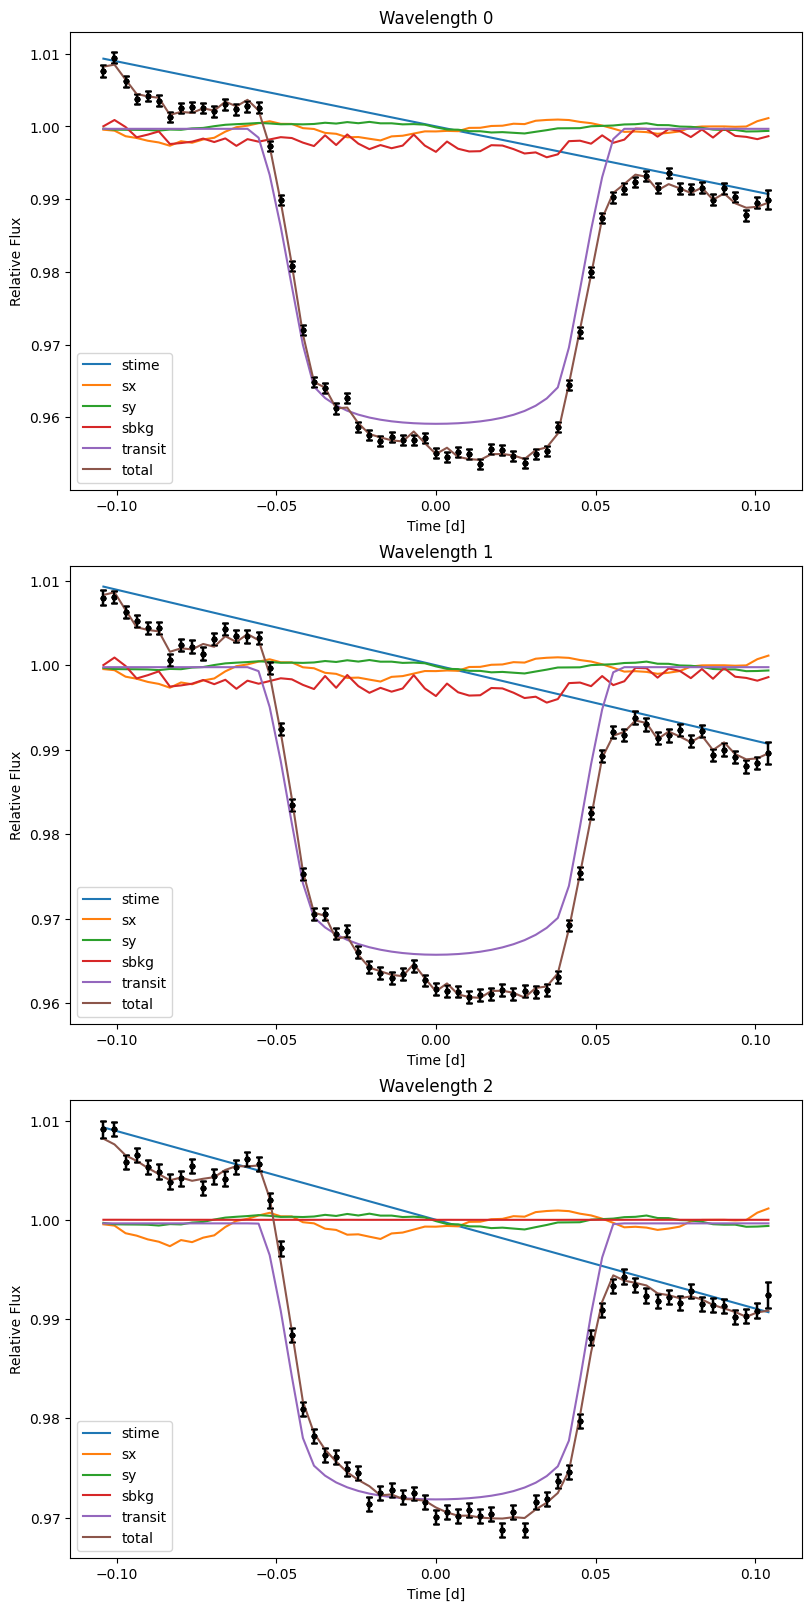

In [18]:
cmod.plot_model()

We can also just choose to see a single model or wavelength:

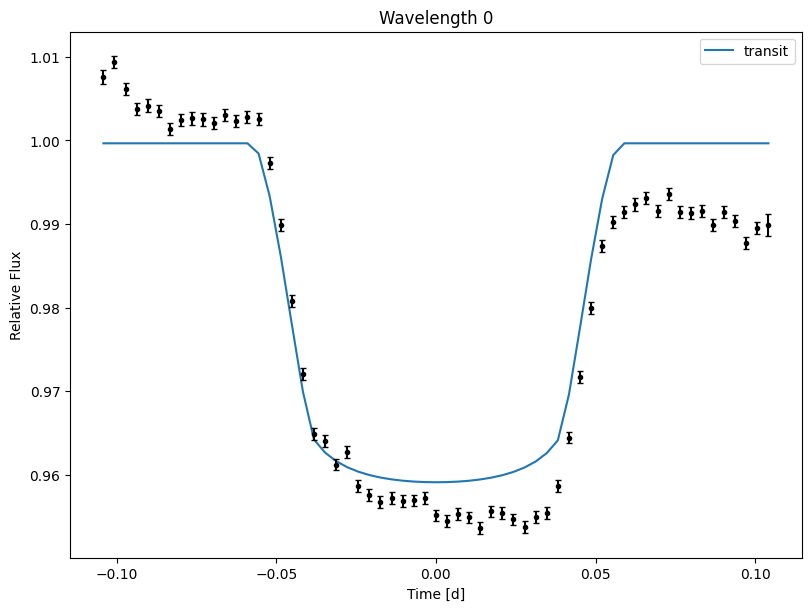

In [19]:
cmod._chromatic_models['transit'].plot_model(wavelength=0)

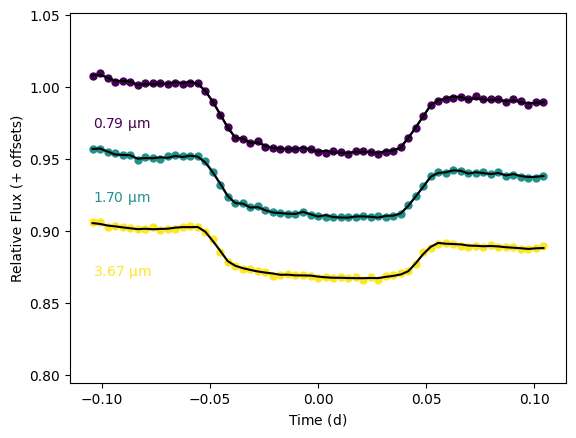

In [20]:
# plot the 2D light curves for each wavelength with the model (black) now overlaid
cmod.plot_lightcurves()

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model


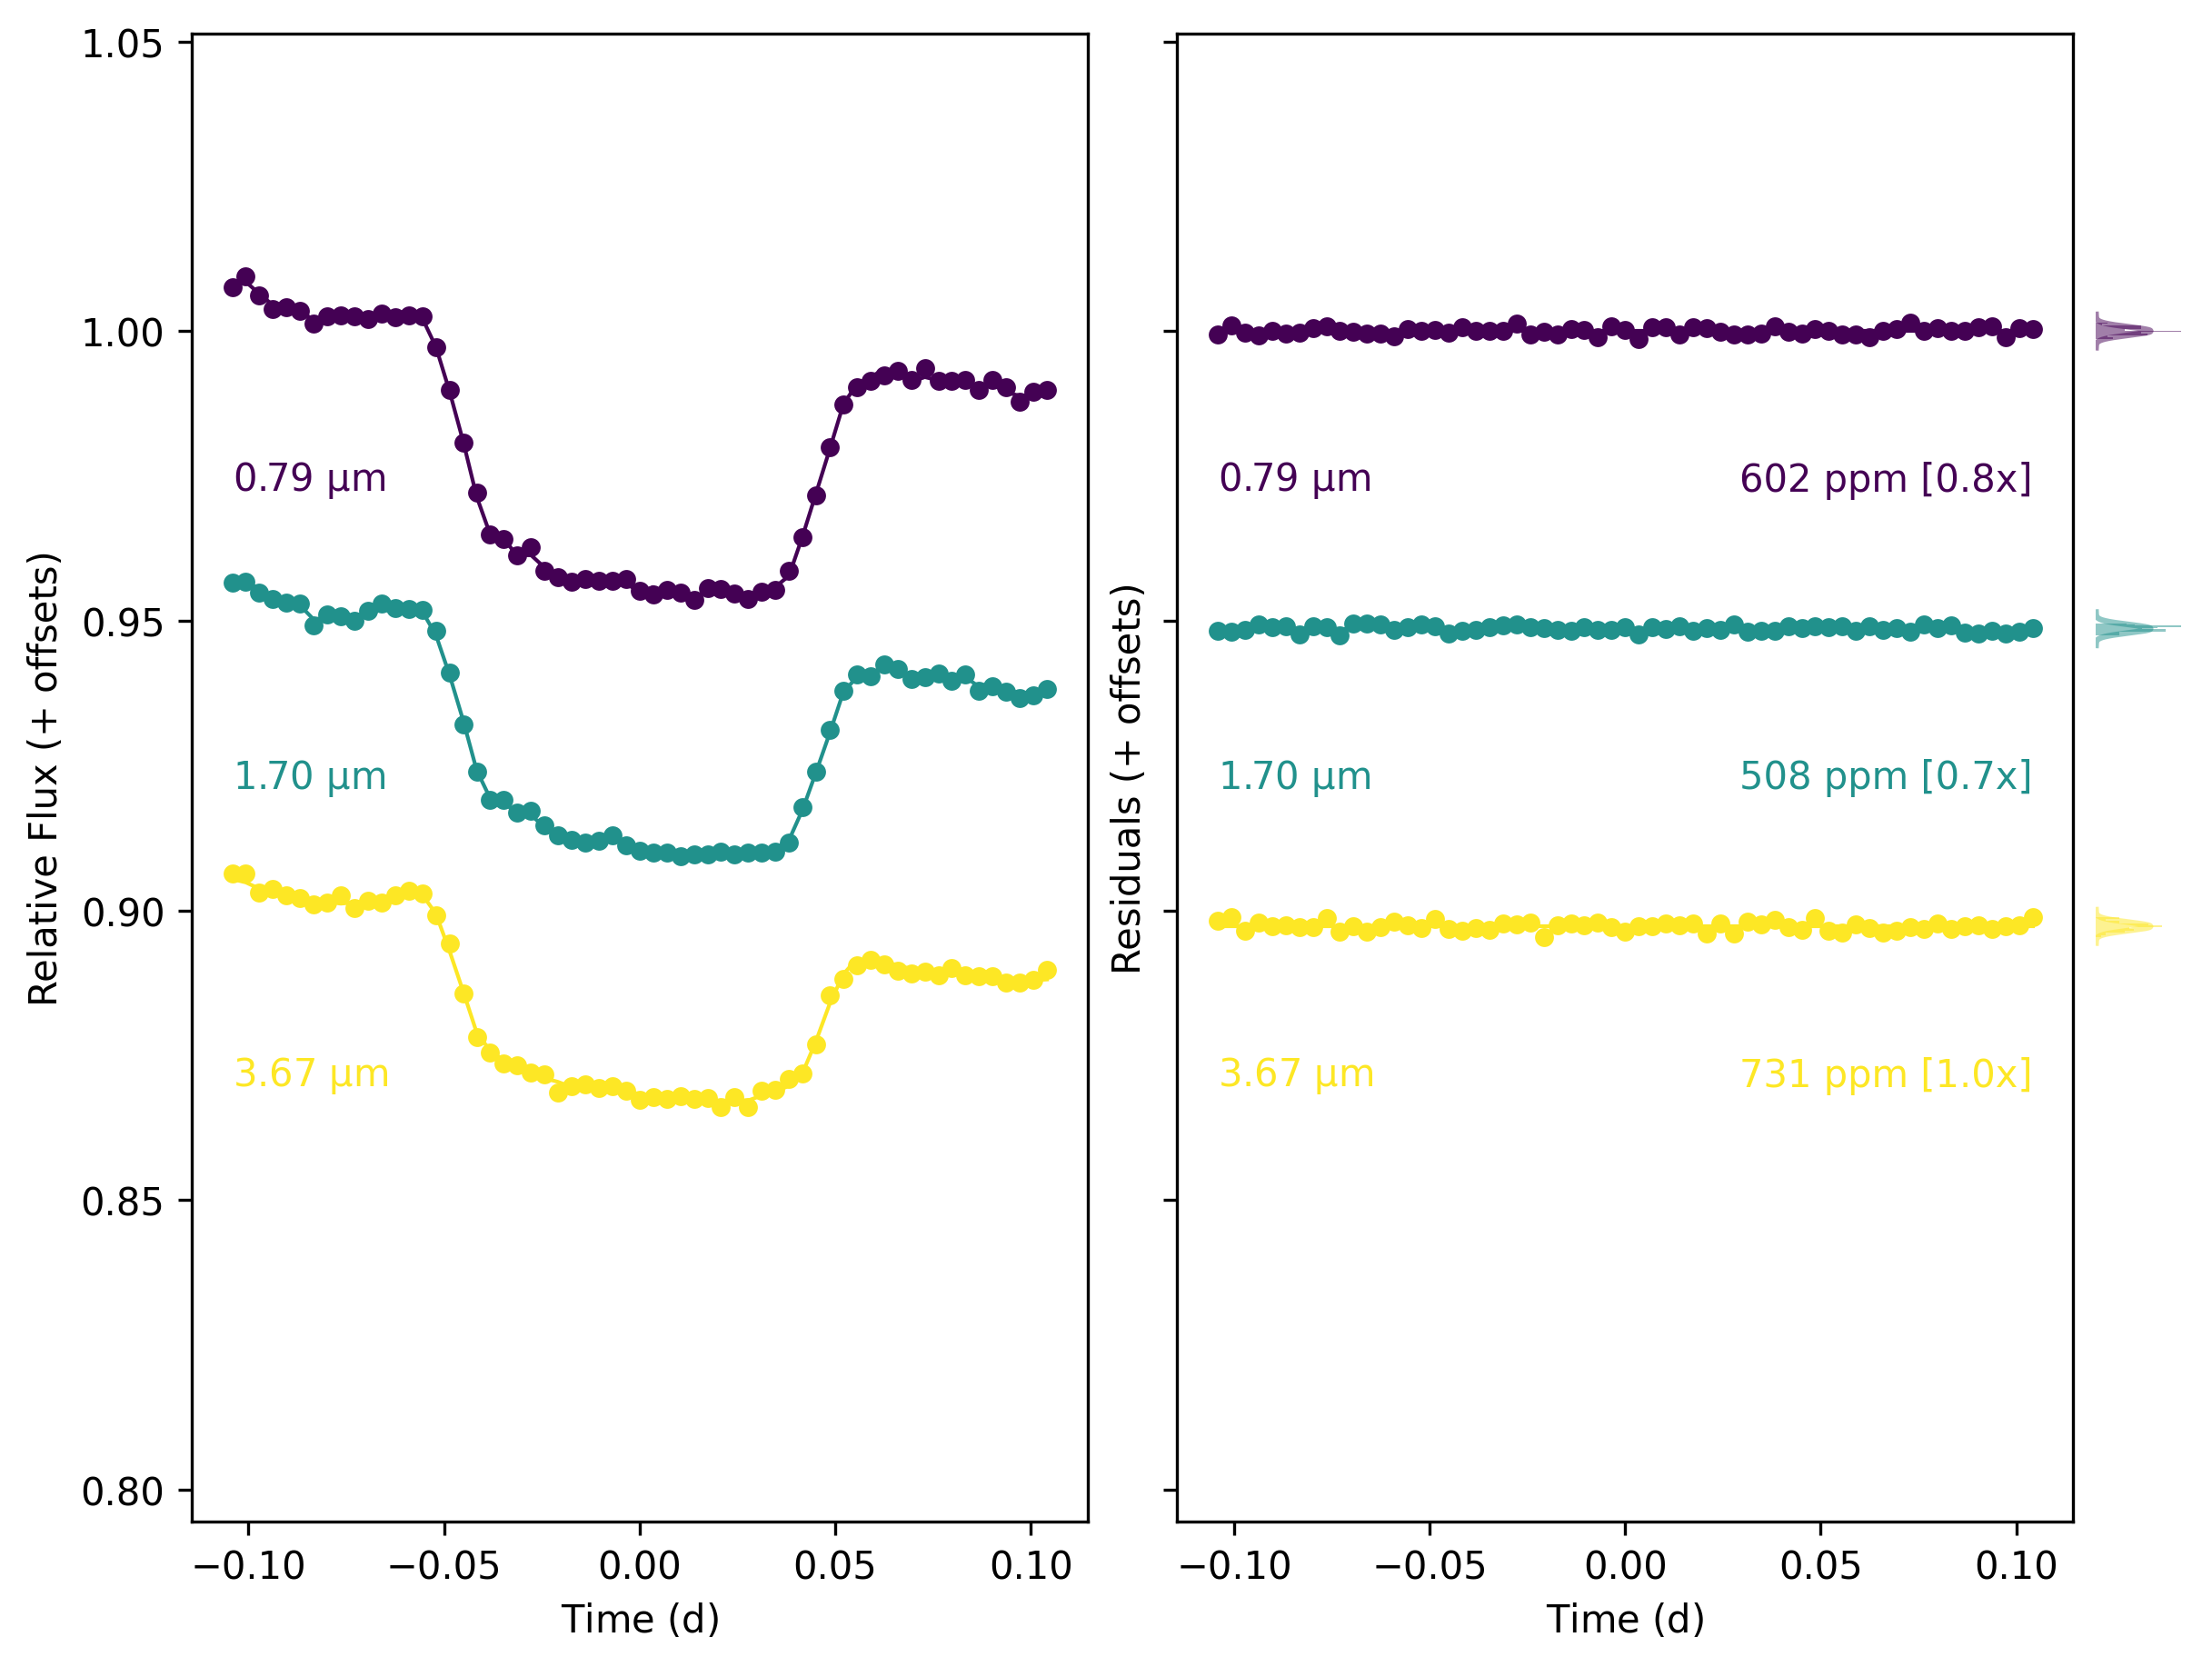

In [21]:
cmod.plot_with_model_and_residuals()

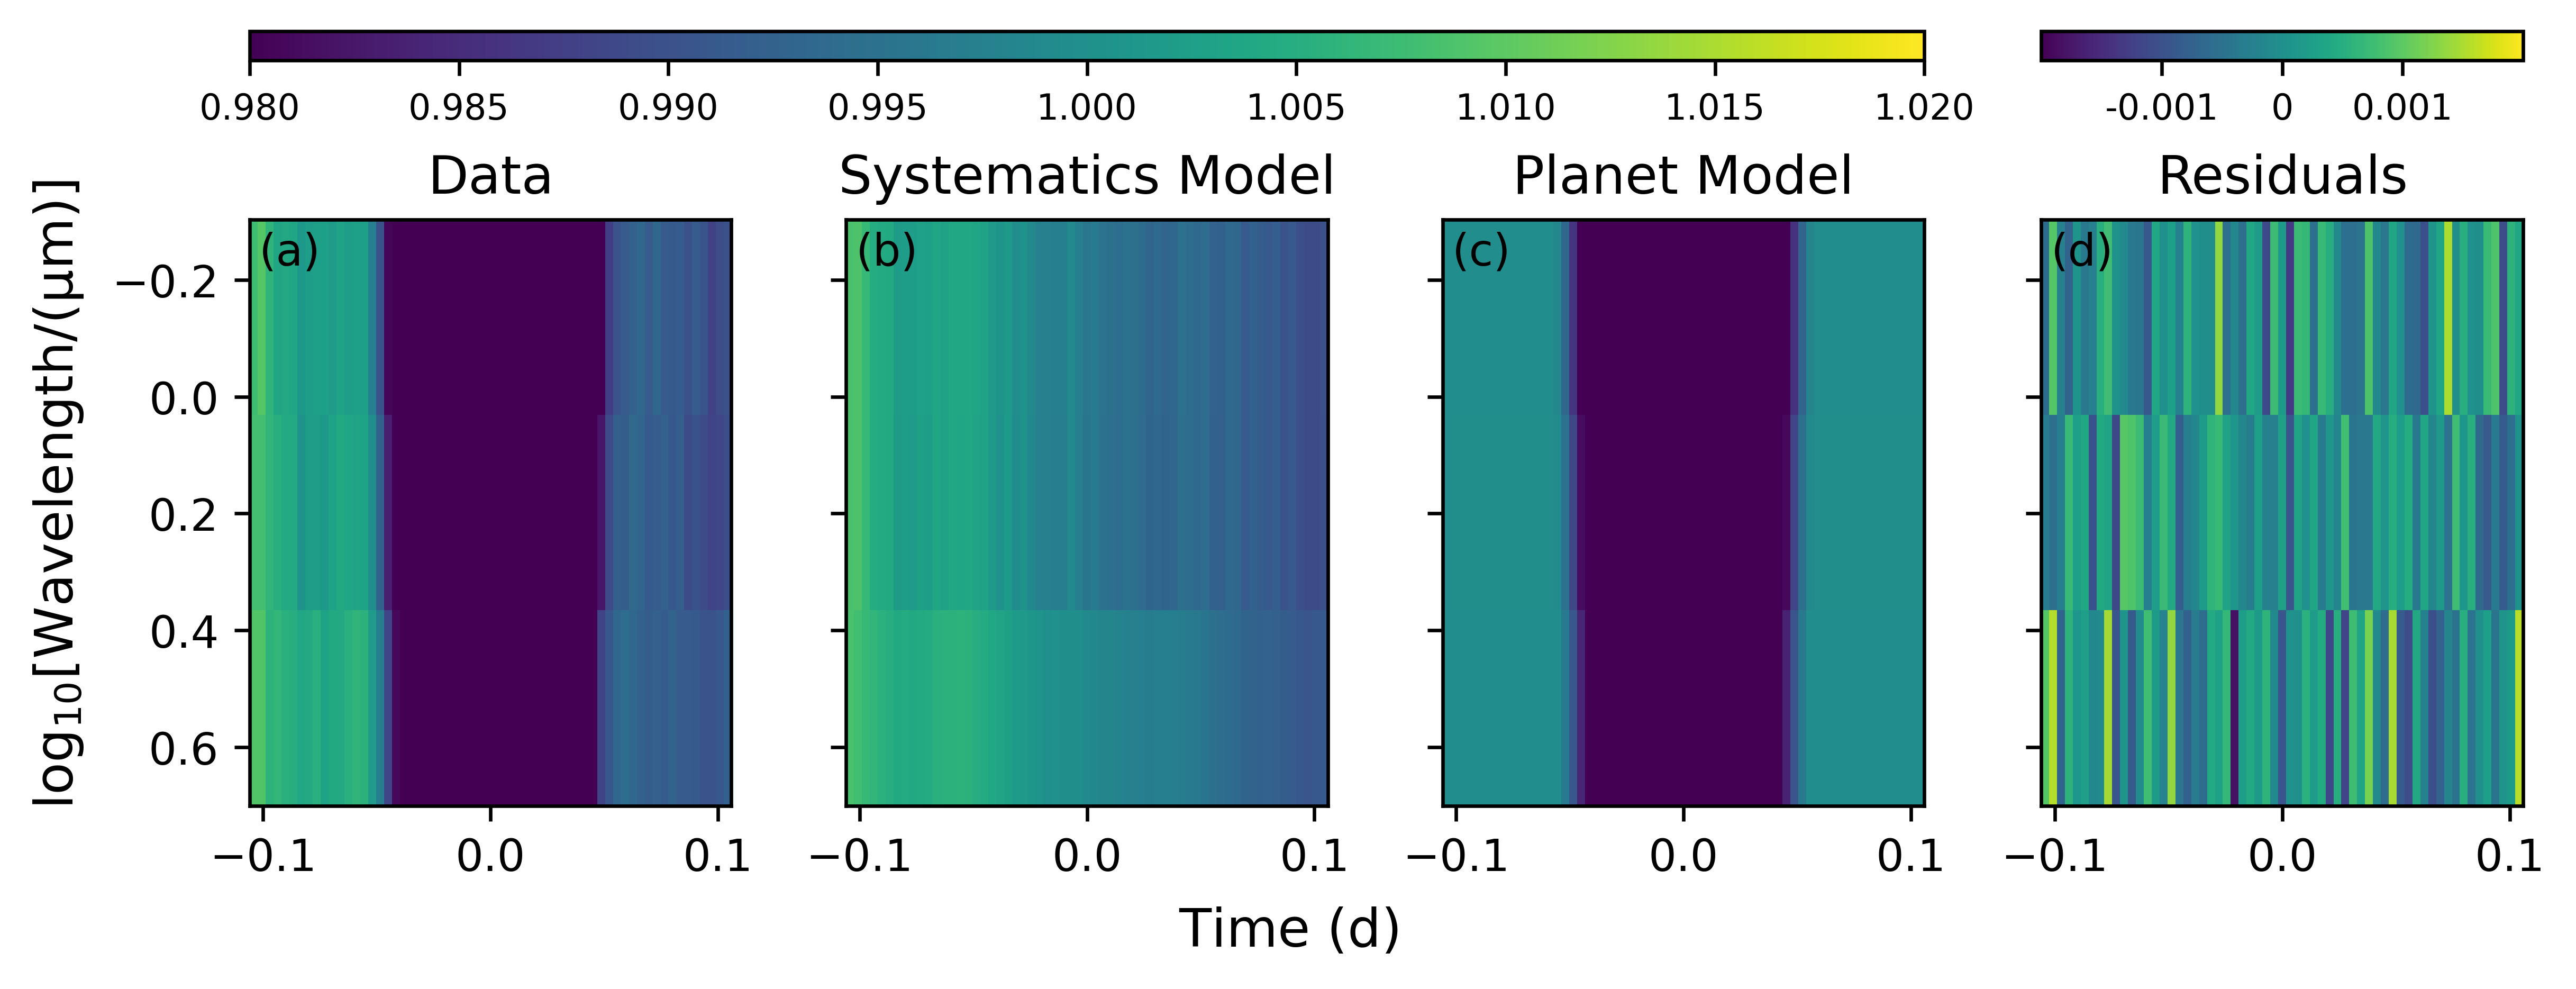

In [24]:
# plot the 3D light curves (flux as a function of time and wavelength) with the residuals
cmod.imshow_with_models(vspan_residuals=0.002)

Plot the transmission spectrum:

Error applying plot_transmission_spectrum to <chromatic polynomial model 'stime' 🌈>: 'PolynomialModel' object has no attribute 'plot_transmission_spectrum'
Error applying plot_transmission_spectrum to <chromatic polynomial model 'sx' 🌈>: 'PolynomialModel' object has no attribute 'plot_transmission_spectrum'
Error applying plot_transmission_spectrum to <chromatic polynomial model 'sy' 🌈>: 'PolynomialModel' object has no attribute 'plot_transmission_spectrum'
Error applying plot_transmission_spectrum to <chromatic polynomial model 'sbkg' 🌈>: 'PolynomialModel' object has no attribute 'plot_transmission_spectrum'


/Users/camu5866/opt/anaconda3/envs/spec_meeting/lib/python3.9/site-packages/chromatic_fitting/models/transit.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_radius_ratio_neg_error"] = (


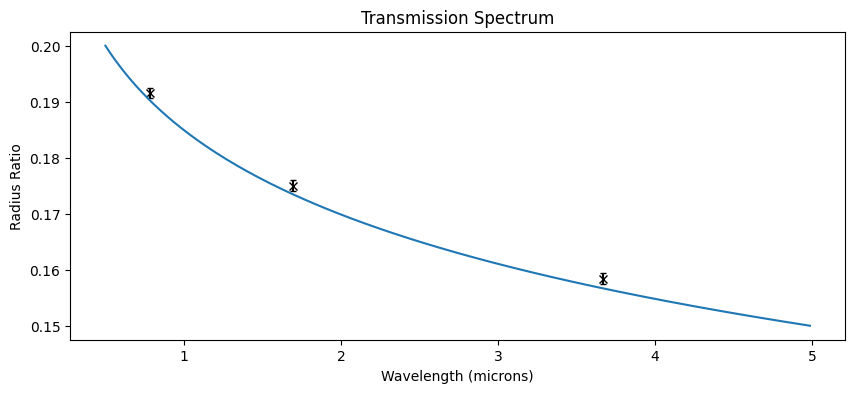

In [23]:
cmod.plot_transmission_spectrum(uncertainty=['hdi_16%','hdi_84%'])
plt.plot(SimulatedRainbow().wavelength, np.linspace(0.2, 0.15, SimulatedRainbow().nwave), label="True Rp/R*");